**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [9]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()
path = './min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,WTICO_USD:binance,XAU_USD:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)


In [11]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv30M = HFDataView()
dv1H = HFDataView()

In [12]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [13]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

In [14]:
Gap30M = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

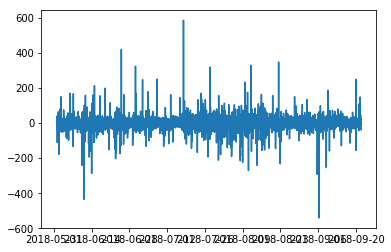

In [15]:
#观察价差
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])

plt.show()

In [16]:
#30min的图

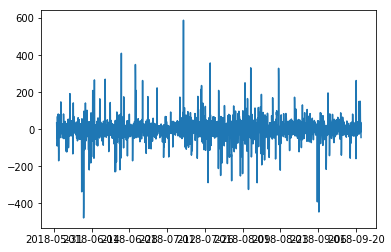

In [17]:

plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

In [18]:
#1H的图

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [28]:
# 进场信号
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [29]:
for dvAdd in [dv30M,dv1H]:
    dvAdd.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0,StdDev(Return(close,1),20),close),2),5)',add_data = True)

Field [alpha1_C] is overwritten.
Field [alpha1_C] is overwritten.


In [30]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [31]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [44]:
for dvAdd in [dv30M,dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

Field [alpha10_C] is overwritten.
Field [alpha10_C] is overwritten.


In [45]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [46]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha1_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

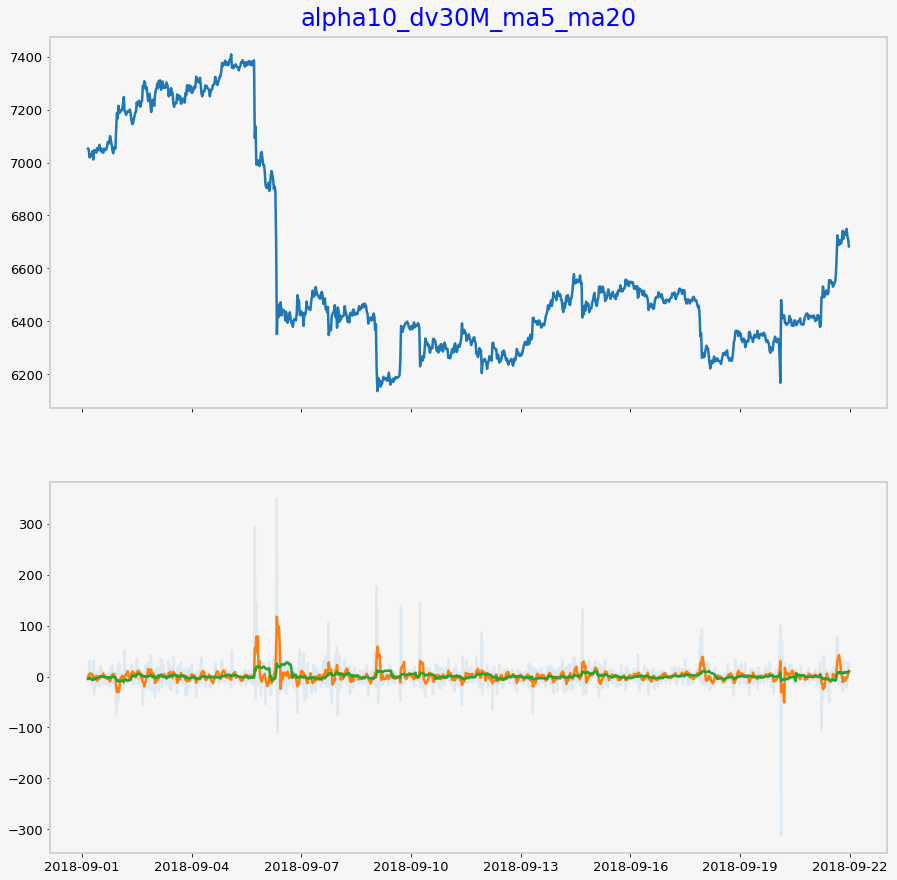

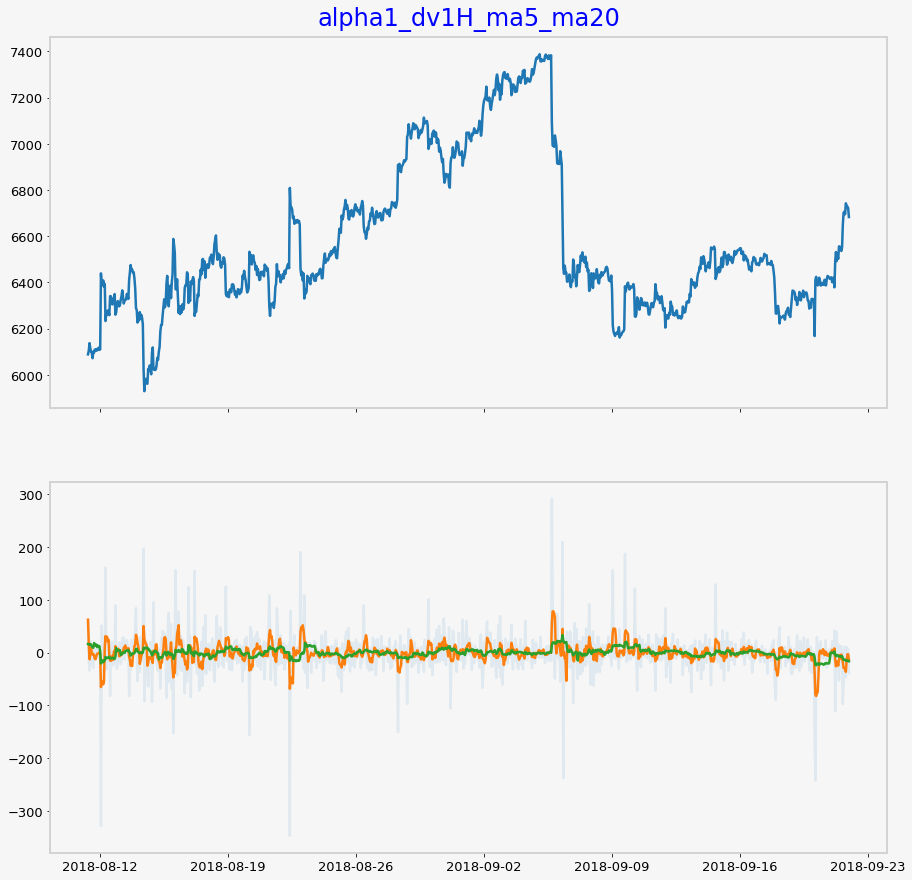

In [47]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [ ]:
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55))&&(Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)",add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55))&&(Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)",add_data=True)

close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)",add_data = True)
close_short = dv1H.add_formula("closeShort","If(short==-2,-1,0)",add_data = True)

In [48]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

In [49]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [50]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha001')

TimingSignal(tdAlpha1, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [51]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [1]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()
path = './min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,WTICO_USD:binance,XAU_USD:binance',
         'freq': '1H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.380000114440918


In [2]:
data1H = Time_dict.set_index('datetime')

In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [4]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [6]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

In [10]:
import talib as ta
Morningstar = dv1H.add_formula('Morningstar',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

Field [Morningstar] is overwritten.


In [11]:
dataMorningstar= dv1H.get_ts('Morningstar', date_type='datetime')

In [12]:
dataMorningstar[dataMorningstar['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [13]:
scatterBigUpX = dataMorningstar[dataMorningstar['BTCUSDT:binance']==100].index

In [14]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [15]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

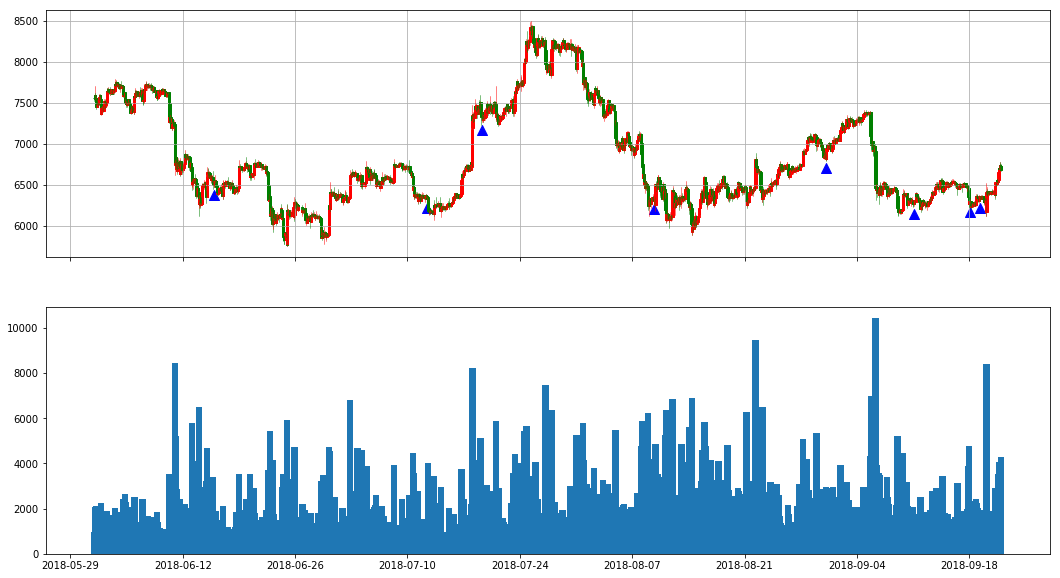

In [16]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
import warnings

warnings.filterwarnings('ignore')

In [18]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'close,low,high','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.4240000247955322


In [19]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [20]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [21]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [22]:
EMA10_J = dv.add_formula('EMA10_J', "Ta('EMA',0,0,0,0,close,0,10)",
                             add_data=True)

In [23]:
ema_plot = dv.get_ts('EMA10_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')


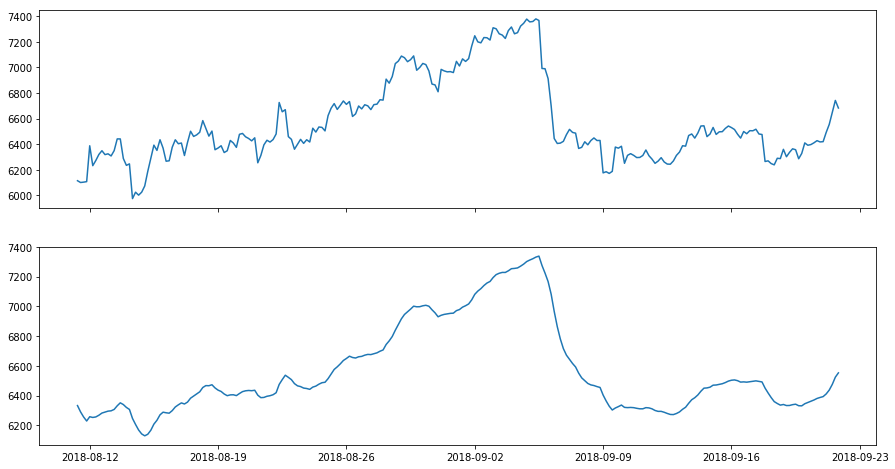

In [24]:
plot_chart(close, ema_plot)

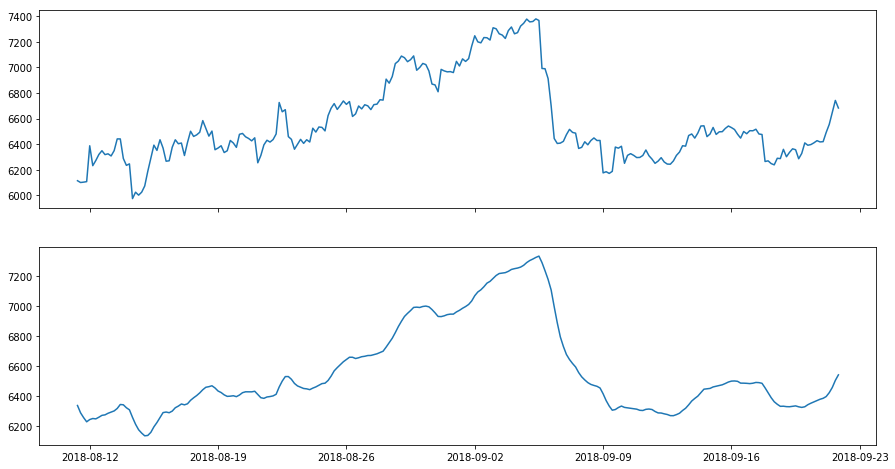

In [25]:
YB = dv.add_formula('YB',"Ta('EMA',0,0,0,0,(close + high + low)/3,10)",add_data = True)
YB_plot = dv.get_ts('YB', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, YB_plot)

In [26]:

ER_Ratio = dv.add_formula('ER_Ratio','(Delta(close,1) - Delta(close,21)) / Ts_Sum(Abs(Delta(close,1) - Delta(close,2)),21)',add_data = True)
ER_plot = dv.get_ts('ER_Ratio', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')


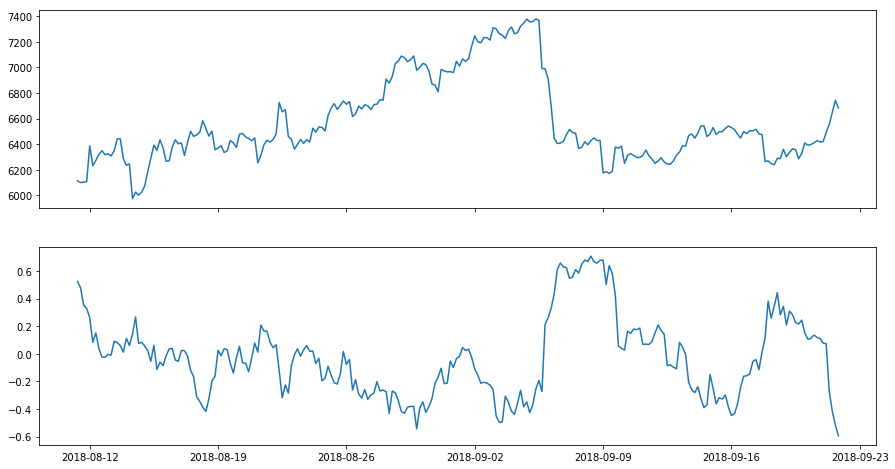

In [27]:
plot_chart(close, ER_plot)

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [28]:
import warnings

warnings.filterwarnings('ignore')

In [29]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

5.812000036239624


In [30]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [41]:
dv.add_formula('Diff_J',
                   "Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",
                   add_data=False)
dv.add_formula('Dea_J',"Ta('EMA',0,0,0,0,Diff_J,0,9)",
                   add_data=False)
MACD_J = dv.add_formula('MACD_J',"(Diff_J-Dea_J)*2",add_data=True)


Field [MACD_J] is overwritten.


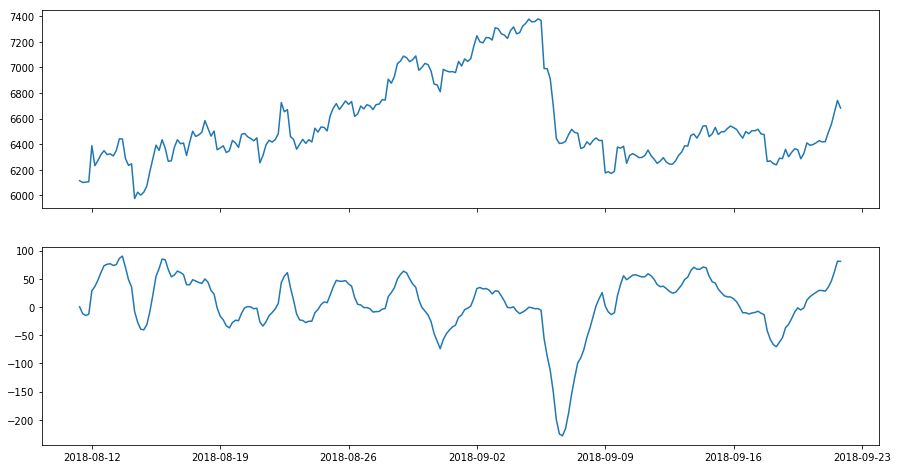

In [42]:
MACD_J_plot = dv.get_ts('MACD_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, MACD_J_plot)

In [ ]:
# 5、设定进出场条件
long = dv1H.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv1H.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
